In [21]:
import os
import sys
import torch
import h5py
import wandb
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import cm, colors
from wandb.apis.public.runs import Runs, Run
from wandb.apis.public.artifacts import RunArtifacts

In [ ]:
def get_model(run: Run, api: wandb.Api) -> str:
    model_path = Path(f"../pretrained_models/{run.id}/ema_model.pth").resolve()
    if not os.path.isfile(model_path):
        arts = RunArtifacts(client=api.client, run=run)
        _ = arts[0].download(root=f"../pretrained_models/{run.id}/")
    return model_path

def plot_M_thin_film2(
    m: np.ndarray,
    res: list[int],
    ax: plt.Axes,
    title: str | None = None,
    scale: float | None = None,
    width: float = 0.002,
    headwidth: float = 3,
    headlength: float = 5,
) -> None:
    '''
    Rework of plot_M_thin_film from magtense.utils to support subplots
    '''
    m = np.permute_dims(m, (1, 2, 0))  # CHW -> HWC
    k = np.moveaxis(m.reshape(res[1], res[0], res[2], 3).swapaxes(0, 1), -1, 0)[
        :, :, :, 0
    ]

    ax.clear()
    ax.quiver(
        k[0].T + 1e-20,
        k[1].T + 1e-20,
        pivot="mid",
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
    )

    nz = colors.Normalize(0.0, 2 * np.pi)
    clr = np.swapaxes(cm.hsv(nz(np.arctan2(k[1], k[0]) + np.pi)), 0, 1)
    ax.imshow(clr, interpolation="bicubic")

    ax.axis("scaled")
    #ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if title:
        ax.set_title(title)

In [29]:
API = wandb.Api()
wandb_cfg = OmegaConf.load("../conf/train.yaml").wandb

filters = {}#{"job_type": "train"} #{"tags": "fine-tune"}

runs = Runs(
    client=API.client,
    entity=wandb_cfg.entity,
    project=wandb_cfg.project,
    filters=filters
)

for i, run in enumerate(runs):
    print(f"Index: {i} - Run ID: {run.id}, Name: {run.name}")

Index: 0 - Run ID: jjj9pelv, Name: heat-logt/joint/unet-v2
Index: 1 - Run ID: 0pp5ahlc, Name: heat-logt/joint/unet-v2/fine-tune
Index: 2 - Run ID: 7revrf5r, Name: heat-no-cond/joint/unet-small
Index: 3 - Run ID: 1ml9aurp, Name: heat-lineart/joint/unet-v2
Index: 4 - Run ID: qbd7omen, Name: heat-lineart/joint/unet-v2/fine-tune
Index: 5 - Run ID: s42g9h6h, Name: heat_no_cond_test/dataset
Index: 6 - Run ID: xo3rg6u8, Name: heat-no-cond/joint/unet-small/test
Index: 7 - Run ID: s6svnr60, Name: heat-no-cond/joint/unet-small/test
Index: 8 - Run ID: 6usadlpw, Name: heat-logt/joint/unet-v2/test
Index: 9 - Run ID: 8dp00llj, Name: heat-no-time/joint/unet-small
Index: 10 - Run ID: 9vsc0osd, Name: heat-no-time/joint/unet-small/test
Index: 11 - Run ID: hsjrwptv, Name: heat-no-time/joint/unet-small/test
Index: 12 - Run ID: beuvkdus, Name: heat-no-time/joint/unet-v2
Index: 13 - Run ID: ehi00g22, Name: heat-no-time/joint/unet-v2/test
Index: 14 - Run ID: 5gf2x0m8, Name: llg-no-time/joint/unet-v2
Index: 1

In [39]:
run_idx = 14
run_cfg = OmegaConf.create(runs[run_idx].config)

model_path = get_model(runs[run_idx], API)
print(f"Model path: {model_path}")

edm = dpde.utils.get_net_from_config(run_cfg)
edm.load_state_dict(torch.load(model_path, weights_only=True))

Model path: /home/s204790/dynamical-pde-diffusion/pretrained_models/5gf2x0m8/ema_model.pth


<All keys matched successfully>

In [31]:
root_dir = dpde.utils.get_repo_root()
data_dir = root_dir / "data" 

In [32]:
with h5py.File(data_dir / "llg_no_time_test.hdf5", "r") as f:
    data = f["U"][:]
    labels = f["labels"][:]
    t_steps = f["t_steps"][:]
    attrs = dict(f.attrs)
res = attrs["res"]

In [33]:
print(f"Data shape: {data.shape}") 
print(f"Labels shape: {labels.shape}")
print(f"time steps: {t_steps}")

Data shape: (200, 3, 64, 16, 2)
Labels shape: (200, 3)
time steps: [0.000e+00 2.235e-09]


In [37]:
dx = attrs["dx"]
dy = attrs["dy"]
T = attrs["T"]
res = attrs["res"]
grid_size = attrs["grid_size"]

In [63]:
idx = 10   # which sample to visualize
t_idx = 1  # which time step to visualize

t = t_steps[t_idx].item()
lbl = labels[idx, :]
a = data[idx, ... , 0]  # (S, S)
u = data[idx, ... , t_idx]  # (S, S)

a.shape, u.shape

((3, 64, 16), (3, 64, 16))

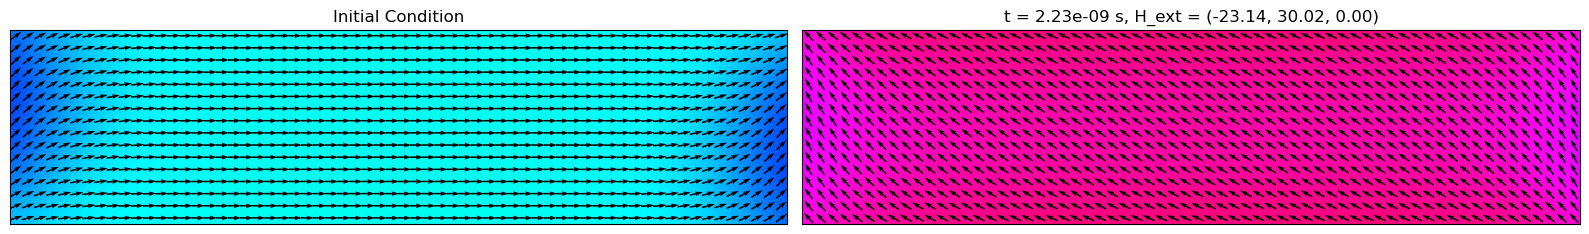

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(a, res=res, ax=axs[0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
plt.tight_layout()
plt.show()

In [65]:
obs_a = torch.tensor(a)
obs_u = torch.tensor(u)
OBS = torch.stack([obs_a, obs_u], dim=0)

ch_a = 3 if run_cfg.dataset.method == "joint" else 0

sample_shape = (16, 6, 64, 16)

generator = torch.Generator().manual_seed(0)

interior_a = 1.0
interior_u = 0.0
boundary_a = 1.0
boundary_u = 0.0
same_boundary = False
boundary_obs_a = dpde.model_testing.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_a)
if same_boundary:
    boundary_obs_u = boundary_obs_a[:]
else:
    boundary_obs_u = dpde.model_testing.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_u)
interior_obs_a = dpde.model_testing.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_a)
interior_obs_u = dpde.model_testing.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_u)

mask_a = dpde.model_testing.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.model_testing.combine_masks(boundary_obs_u, interior_obs_u)

In [66]:
class Sampler:

    def __init__(
        self,
        net,
        device,
        sample_shape,
        num_channels,
        num_samples,
        ch_a,
        loss_fn,
        loss_kwargs,
        num_steps=18,
        sigma_min=0.002,
        sigma_max=80.0,
        rho=7.0,
        out_and_grad_fn=dpde.sampling.X_and_dXdt_fd,
    ):
        self.net = net
        self.device = device
        self.sample_shape = sample_shape
        self.num_channels = num_channels
        self.num_samples = num_samples
        self.ch_a = ch_a
        self.loss_fn = loss_fn
        self.loss_kwargs = loss_kwargs
        self.num_steps = num_steps
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        self.out_and_grad_fun = out_and_grad_fn

        self.dtype_f = torch.float32     # net runs in fp32
        self.dtype_t = torch.float64     # keep time grid in fp64 for stability, as in EDM

    def sample(
        self,
        labels,
        obs_a,
        obs_u,
        mask_a,
        mask_u,
        zeta_a,
        zeta_u,
        zeta_pde,
        return_losses=False,
        num_steps=None,
        sigma_min=None,
        sigma_max=None,
        rho=None,
    ):
        dt_f = self.dtype_f
        dt_t = self.dtype_t

        obs_u, mask_u = obs_u.to(device=self.device, dtype=dt_t), mask_u.to(device=self.device, dtype=dt_t)
        obs_a, mask_a = obs_a.to(device=self.device, dtype=dt_t), mask_a.to(device=self.device, dtype=dt_t)

        num_steps = num_steps if num_steps is not None else self.num_steps
        sigma_min = sigma_min if sigma_min is not None else self.sigma_min
        sigma_max = sigma_max if sigma_max is not None else self.sigma_max
        rho = rho if rho is not None else self.rho

        step_idx = torch.arange(num_steps, dtype=dt_t, device=self.device)
        sigmas = (sigma_max**(1.0/rho) + step_idx/(num_steps-1) * (sigma_min**(1.0/rho) - sigma_max**(1.0/rho)))**rho
        sigmas = getattr(self.net, "round_sigma", lambda x: x)(sigmas)
        sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # length N+1, last = 0

        B = labels.shape[0] if labels is not None else self.num_samples
        if labels is not None:
            labels = labels.to(device=self.device, dtype=dt_f)
        
        latents = torch.randn((B, self.num_channels, *self.sample_shape), device=self.device, dtype=dt_t)

        x_next = (latents.to(self.dtype_t) * sigmas[0])

        losses = torch.zeros((num_steps, 4))  # for debugging

        for i, (sigma_cur, sigma_next) in enumerate(zip(sigmas[:-1], sigmas[1:])):  # i = 0..N-1
            x_cur = x_next.detach().clone()
            x_cur.requires_grad = True
            # Euler step to t_next
            x_N, dxdt = self.out_and_grad_fun(self.net, x_cur.to(dt_f), torch.full((B,), sigma_cur, device=self.device, dtype=dt_f), labels)
            x_N, dxdt = x_N.to(dt_t), dxdt.to(dt_t)
            
            d_cur = (x_cur - x_N) / sigma_cur
            x_next = x_cur + (sigma_next - sigma_cur) * d_cur
            # Heun (2nd-order) correction unless final step
            if i < num_steps - 1:
                x_N, dxdt = self.out_and_grad_fun(self.net, x_next.to(dt_f), torch.full((B,), sigma_next, device=self.device, dtype=dt_f), labels)
                x_N, dxdt = x_N.to(dt_t), dxdt.to(dt_t)
                d_prime = (x_next - x_N) / sigma_next
                x_next = x_cur + (sigma_next - sigma_cur) * (0.5 * d_cur + 0.5 * d_prime)

            # observation losses for DPS sampling
            loss_u = torch.zeros(1, dtype=dt_t, device=self.device)
            loss_a = torch.zeros(1, dtype=dt_t, device=self.device)
            if mask_u.sum() > 0:
                loss_u = torch.sqrt(torch.sum((mask_u * (x_N[:, self.ch_a:, :, :] - obs_u)) ** 2))
            if mask_a.sum() > 0:
                loss_a = torch.sqrt(torch.sum((mask_a * (x_N[:, :self.ch_a, :, :] - obs_a)) ** 2))

            # PDE loss for DPS sampling
            dudt = dxdt[:, self.ch_a:, :, :]
            u_N = x_N[:, self.ch_a:, :, :]
            loss_pde = self.loss_fn(u_N, dudt, **self.loss_kwargs)
            if i <= 0.8 * num_steps:
                w_a, w_u, w_pde = zeta_a, zeta_u, zeta_pde
            else:
                w_a, w_u, w_pde = 0.1 * zeta_a, 0.1 * zeta_u, zeta_pde
            
            loss_comb = w_a * loss_a + w_u * loss_u + w_pde * loss_pde
            grad_x = torch.autograd.grad(loss_comb, x_cur, retain_graph=False)[0]
            x_next = x_next - grad_x
            
            losses[i] = torch.tensor([loss_a.item(), loss_u.item(), loss_pde.item(), loss_comb.item()])        

        # Return at sigma=0 in fp32
        x = x_next.to(dt_f).detach().cpu()

        losses = losses.detach().cpu().numpy() if return_losses else None        
        return x, losses

In [67]:
def temp_llg_loss(u, dudt, dx, dy):
    norm = torch.linalg.norm(u, dim=1)
    loss = torch.sqrt(torch.sum((1 - norm) ** 2)) / (u.shape[2] * u.shape[3])  # normalize by spatial size
    return loss

In [68]:
sampler = Sampler(
    net=edm,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    sample_shape=(64, 16),
    num_channels=6 if run_cfg.dataset.method == "joint" else 3,
    num_samples=16,
    ch_a=3 if run_cfg.dataset.method == "joint" else 0,
    loss_fn=temp_llg_loss,
    loss_kwargs={"dx": dx, "dy": dy},
    num_steps=50,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
)

In [69]:
from magtense.micromag import MicromagProblem


def llg_loss(
    x, dxdt, obs_a, obs_u, mask_a, mask_u, dx, dy, ch_a, labels, cuda: bool = True
):
    """
    Compute the Landau-Lifshitz-Gilbert (LLG) equation loss components.

    LLG in MagTense notation:
        dm_dt = - gamma * (m x H_eff) - alpha * m x (m x H_eff)
        H_eff = H_ext + H_demag + H_exch + H_anis

    Choice for muMAG Std problem #4 (https://www.ctcms.nist.gov/~rdm/std4/spec4.html):
        H_anis = 0
        H_ext = (known) constant external field
        H_demag = computed via magnetostatic equations (not included here)
        H_exch = (2 A / (mu0 Ms)) * Laplacian(m)

    Following parameters are fixed for simplicity, can be modified as needed:
        gamma = 2.21e5  # gyromagnetic ratio [m/(A s)]
        alpha = 4.42e3  # damping constant
        A0 = 1.3e-11    # exchange stiffness [J/m]
        Ms = 8e5        # saturation magnetization [A/m]
        K0 = 0.0        # anisotropy constant [J/m^3]

    Parameters
    ----------
    x : torch.Tensor
        Current state tensor of shape (B, C, H, W), where C = ch_a + ch_u.
    dxdt : torch.Tensor
        Time derivative of x, tensor of shape (B, C, H, W).
    obs_a : torch.Tensor
        Observations of the initial condition, tensor of shape (B, ch_a, H, W).
    obs_u : torch.Tensor
        Observations of the solution at time T, tensor of shape (B, ch_u, H, W).
    mask_a : torch.Tensor
        Binary mask for obs_a, tensor of shape (B, ch_a, H, W).
    mask_u : torch.Tensor
        Binary mask for obs_u, tensor of shape (B, ch_u, H, W).
    dx : float
        Spatial grid size in x-direction.
    dy : float
        Spatial grid size in y-direction.
    ch_a : int
        Number of channels for the initial condition.
    labels : torch.Tensor
        External magnetic field vector of shape (B, 3).

    Returns
    -------
    loss_pde : torch.Tensor
        PDE loss component.
    loss_obs_a : torch.Tensor
        Observation loss component for the initial condition.
    loss_obs_u : torch.Tensor
        Observation loss component for the solution at time T.
    """
    # Magnetization vector (B, 3, H, W)
    m = x[:, ch_a:, :, :]
    # Initial condition vector (B, ch_a, H, W)
    a = x[:, :ch_a, :, :]
    n_magnets = m.shape[-1] * m.shape[-2]
    # Time derivative of Magnetization vector (B, 3, H, W)
    dmdt = dxdt[:, ch_a:, :, :]

    dtype = torch.float32
    res = [64, 16, 1]
    grid_size = [500e-9, 125e-9, 3e-9]
    mu0 = 4e-7 * torch.pi
    t_per_step = 4e-12
    gamma = 2.21e5
    alpha = 4.42e3
    A0 = 1.3e-11
    Ms = 8e5
    K0 = 0.0

    # Reshape to (B, 3, 1, 1) for broadcasting and bring to units [A/m]
    h_ext = (labels.view(x.shape[0], 3, 1, 1) / (1000 * mu0)).detach().cpu()
    h_eff = torch.zeros_like(m).detach().cpu()

    # Iterate over batch dimension to compute fields for each sample
    for i in range(m.shape[0]):
        n_magnets = res[0] * res[1] * res[2]

        # Reshape from  (3, H, W) to (n_magnets, 3)
        m_mt = m[i].swapaxes(1, 2).reshape(3, -1).T.detach().cpu().numpy()
        problem_dym = MicromagProblem(
            res=res,
            grid_L=grid_size,
            m0=m_mt,
            alpha=alpha,
            gamma=gamma,
            A0=A0,
            Ms=Ms,
            K0=K0,
            usereturnhall=1,
            cuda=cuda,
        )

        def h_ext_fct(t) -> np.ndarray:
            return np.expand_dims(t > -1, axis=1) * h_ext[i, :, 0, 0].detach().cpu().numpy()

        devnull = open("/dev/null", "w")
        oldstdout_fno = os.dup(sys.stdout.fileno())
        os.dup2(devnull.fileno(), 1)
        h_e, _, h_d, h_a = problem_dym.run_simulation(
            t_end=t_per_step * 9,
            nt=10,  # Minimum number of steps for rksuite of MagTense to work properly
            fct_h_ext=h_ext_fct,
            nt_h_ext=100,
        )[3:7]
        os.dup2(oldstdout_fno, 1)

        # Reshape back to (3, H, W) and negate fields as MagTense returns -H
        h_exch = torch.tensor(
            -h_e[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_demag = torch.tensor(
            -h_d[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_anis = torch.tensor(
            -h_a[1, :, 0].copy().T.reshape(3, res[1], res[0]).swapaxes(1, 2),
            dtype=dtype,
        )
        h_eff[i] = h_ext[i] + h_exch + h_demag + h_anis
        
    h_eff = h_eff.to(m.device)
    # Compute the LLG right-hand side
    mxH = torch.cross(m, h_eff, dim=1)
    m_cross_mxH = torch.cross(m, mxH, dim=1)
    llg_rhs = -gamma * mxH - alpha * m_cross_mxH

    loss_pde = (torch.norm(dmdt - llg_rhs * t_per_step, dim=1, p=2) / n_magnets).sum()  #dim=1
    # enforce |m| = 1 constraint
    loss_norm = torch.norm(m, p=2, dim=1) - 1

    loss_obs_a = torch.norm(mask_a * (a - obs_a), p=2)
    loss_obs_u = torch.norm(mask_u * (m - obs_u), p=2)

    return loss_pde, loss_obs_a, loss_obs_u


Final total loss: 0.3579


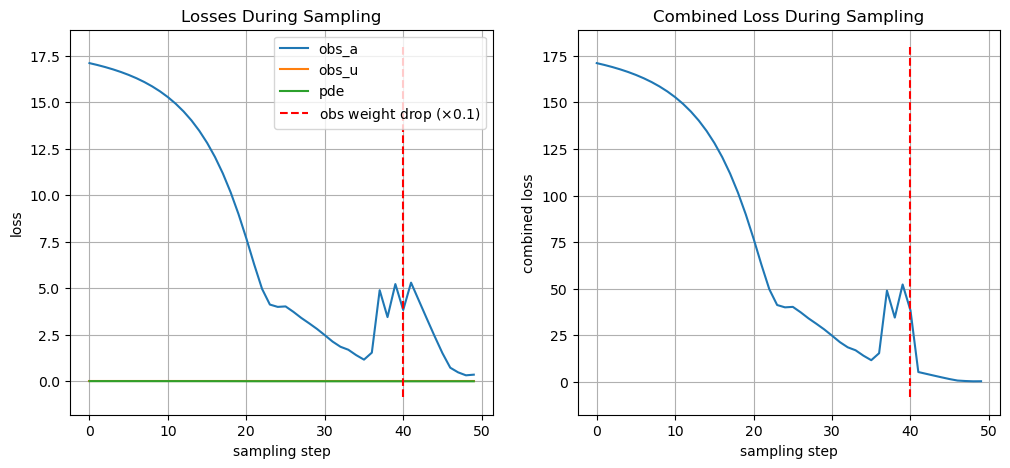

In [70]:
zeta_a = 10.0
zeta_u = 10.0
zeta_pde = 0.5

num_steps = 50

use_t_cond = False
if use_t_cond:
    t_cond = torch.full((sample_shape[0], 1), t)

lbls = torch.tensor(lbl).unsqueeze(0).repeat(sample_shape[0], 1)
if use_t_cond:
    lbls = torch.cat([t_cond, lbls], dim=-1)

with dpde.sampling.sampling_context(sampler):
    samples, losses = sampler.sample(
        labels=lbls,
        obs_a=obs_a,
        obs_u=obs_u,
        mask_a=mask_a,
        mask_u=mask_u,
        zeta_a=zeta_a,
        zeta_u=zeta_u,
        zeta_pde=zeta_pde,
        num_steps=num_steps,
        return_losses=True,
    )
print(f"Final total loss: {losses[-1, 3]:.4f}")
samples = samples.numpy()

legend = ['obs_u', 'pde', 'obs weight drop ($\\times 0.1$)']
if run_cfg.dataset.method == "joint":
    legend = ['obs_a'] + legend

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :-1])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, -1])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(legend)
plt.show()

In [71]:
rng = np.random.default_rng()

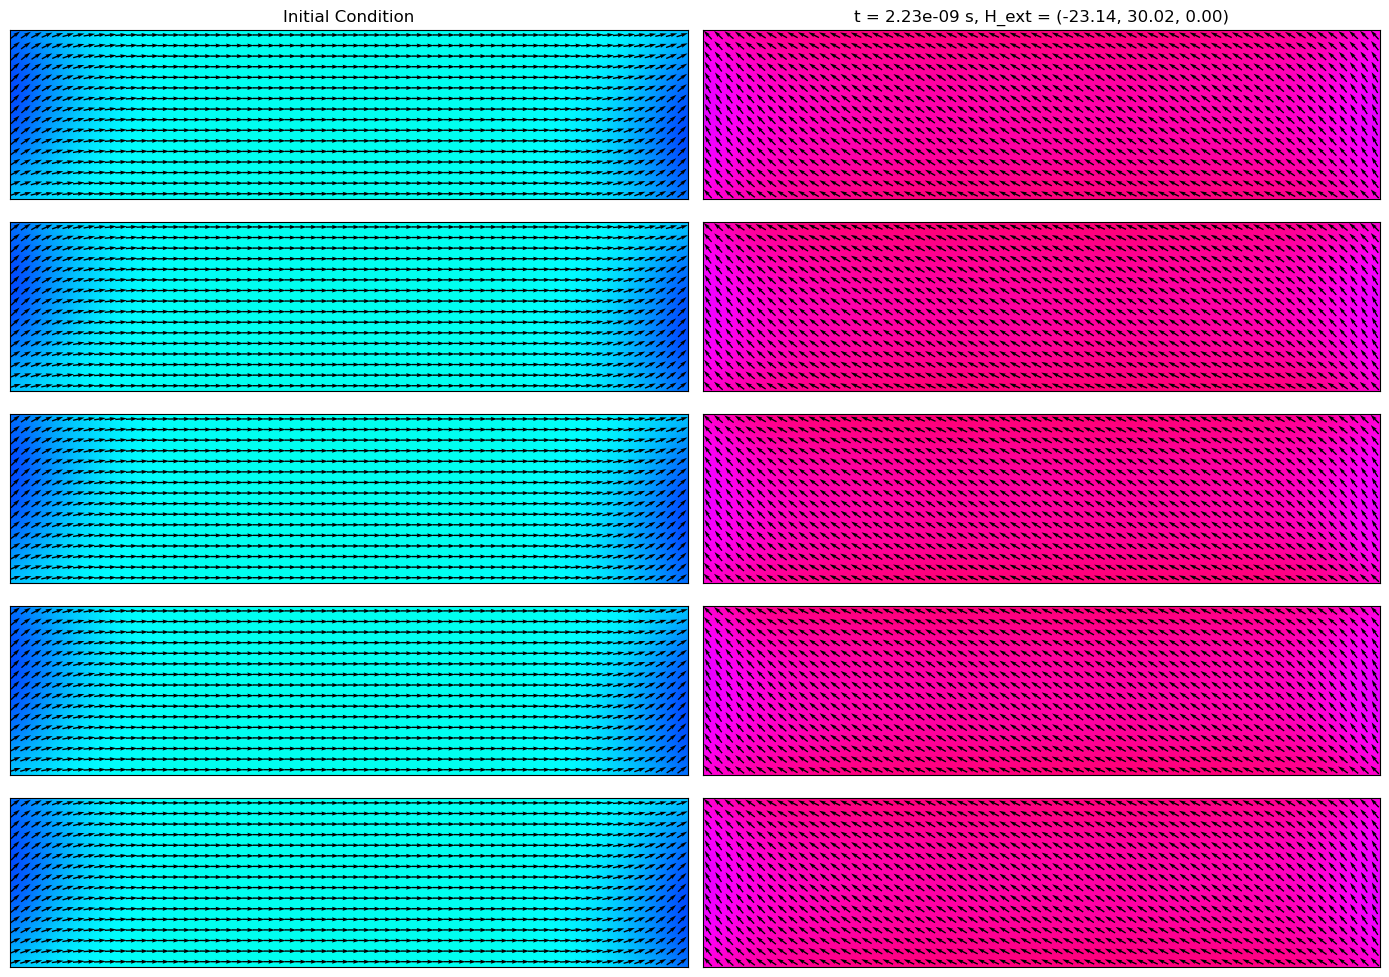

In [72]:
num_samples_plot = 4
fig, axs = plt.subplots(num_samples_plot + 1, 2, figsize=(14, 2 * (num_samples_plot + 1)))

plot_M_thin_film2(a, res=res, ax=axs[0, 0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[0, 1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
for i in range(num_samples_plot):
    idx = rng.integers(0, samples.shape[0])
    plot_M_thin_film2(samples[idx, :ch_a, ...], res=res, ax=axs[i + 1, 0])
    plot_M_thin_film2(samples[idx, ch_a:, ...], res=res, ax=axs[i + 1, 1])
plt.tight_layout()
plt.show()

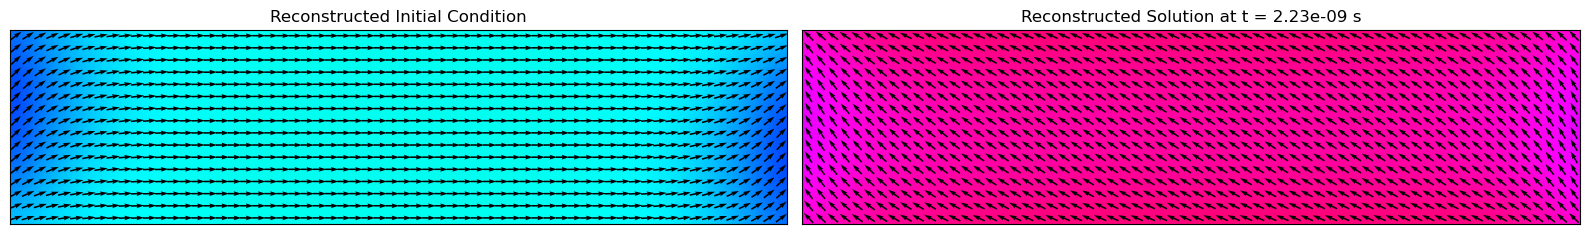

In [73]:
average_a = samples[:, :ch_a, ...].mean(axis=0)
average_u = samples[:, ch_a:, ...].mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(average_a, res=res, ax=axs[0], title="Reconstructed Initial Condition")
plot_M_thin_film2(average_u, res=res, ax=axs[1], title=f"Reconstructed Solution at t = {t:.2e} s")
plt.tight_layout()
plt.show()

In [41]:
samples.shape

(32, 6, 64, 16)

In [42]:
std_u = samples[:, ch_a:, ...].std(axis=(0, 1))

In [43]:
std_u.shape

(64, 16)

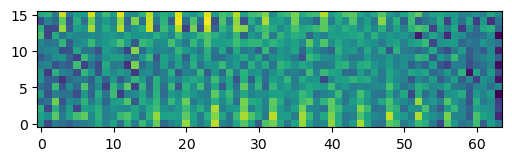

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(std_u.T, cmap='viridis', origin='lower')